# Customer Segmentation for Mall data using K-Means

### Background:
#### Customer segmentation is important for businesses to understand their target audience. Different advertisements can be curated and sent to different audience segments based on their demographic profile, interests, and affluence level.

#### There are many unsupervised machine learning algorithms that can help companies identify their user base and create consumer segments.

#### In this project, we will be looking at a popular unsupervised learning technique called K-Means clustering.



#### Imports and reading the data frame
#### Run the following lines of code to import the necessary libraries and read the dataset:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sea
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# reading the data frame

df = pd.read_csv('Mall_Customers.csv')

%pwd

FileNotFoundError: [Errno 2] No such file or directory: 'Mall_Customers.csv'

#### Displaying the head of the dataset 

In [66]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,0
1,Male,21,15,81,1
2,Female,20,16,6,0
3,Female,23,16,77,1
4,Female,31,17,40,0


#### There are five variables in the dataset. CustomerID is the unique identifier of each customer in the dataset, and we can drop this variable. It doesn't provide us with any useful cluster information.

#### Since gender is a categorial variable, it needs to be encoded and converted into numeric.

#### All other variables will be scaled to follow a normal distribution before being fed into the model. We will standardize these variables with a mean of 0 and a standard deviation of 1.

### Standardizing variables
#### First, lets standardize all variables in the dataset to get them around the same scale.

In [46]:
col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


### Transforming variables

In [47]:
gender = df['Gender']
newdf = scaled_features.join(gender)

newdf = pd.get_dummies(newdf, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

newdf = newdf.drop(['Gender_Male'],axis=1)

newdf.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1


### Building the clustering model



Text(0, 0.5, 'Inertia')

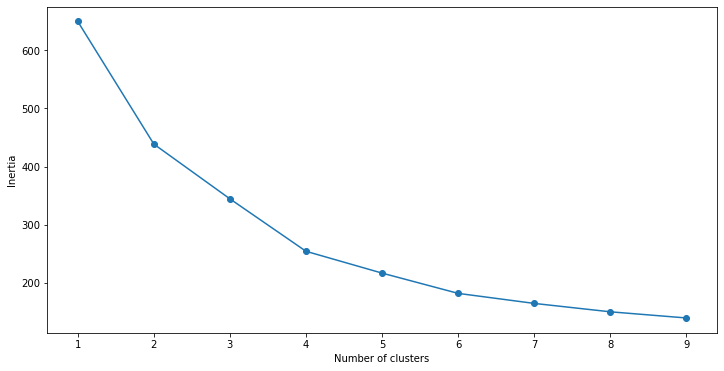

In [48]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(newdf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

#### We can see the optimal number of clusters is 4
##### Now, lets take a look at another clustering metric.



# Silhouette coefficient

#### Lets calculate the silhouette score of the model we just built:

In [49]:
# First, build a model with 4 clusters

kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(newdf)

# Now, print the silhouette score of this model

print(silhouette_score(newdf, kmeans.labels_, metric='euclidean'))

0.35027020434653977


#### The silhouette score of this model is about 0.35.

#### This isn't a bad model, but we can do better and try getting higher cluster separation.

#### Before we try doing that, lets visualize the clusters we just built to get an idea of how well the model is doing:

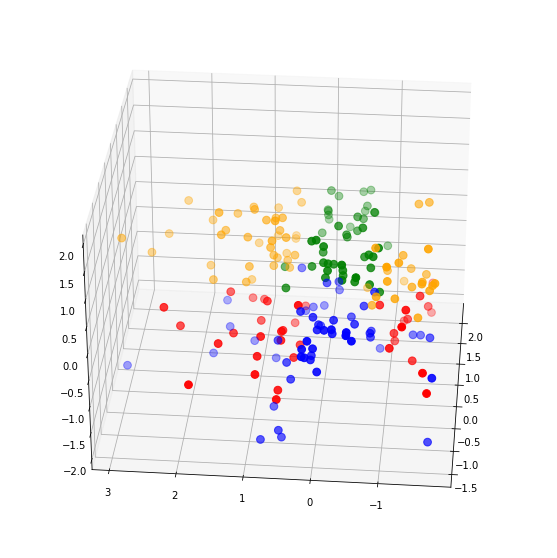

In [50]:
clusters = kmeans.fit_predict(newdf.iloc[:,1:])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)

ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)
ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

#### From the above diagram, we can see that cluster separation isn't too great.
#### This, along with the silhouette score shows us that the model isn't performing too well.

### Building clustering model #2

#### Let's try Principal Component Analysis (PCA).
#### We can use a technique called Principal Component Analysis (PCA).

#### PCA is a technique that helps us reduce the dimension of a dataset. When we run PCA on a data frame, new components are created. These components explain the maximum variance in the model.

#### We can select a subset of these variables and include them into the K-means model.

#### Now, lets run PCA on the dataset:



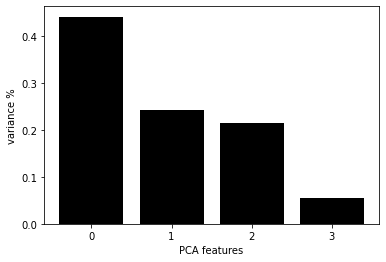

In [51]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

#### This chart shows us each PCA component, along with it variance.

#### Based on this visualization, we can see that the first two PCA components explain around 70% of the dataset variance.

#### We can feed these two components into the model.

#### Lets build the model again with the first two principal components, and decide on the number of clusters to use:

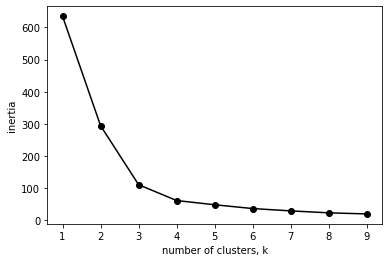

In [52]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#### Again, it looks like the optimal number of clusters is 4.
#### We can calculate the silhouette score for this model with 4 clusters:

In [53]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean')) 

0.6305183888723045


#### The silhouette score of this model is 0.49, which is better than the previous model we created.

#### We can visualize the clusters for this model just like we did earlier:

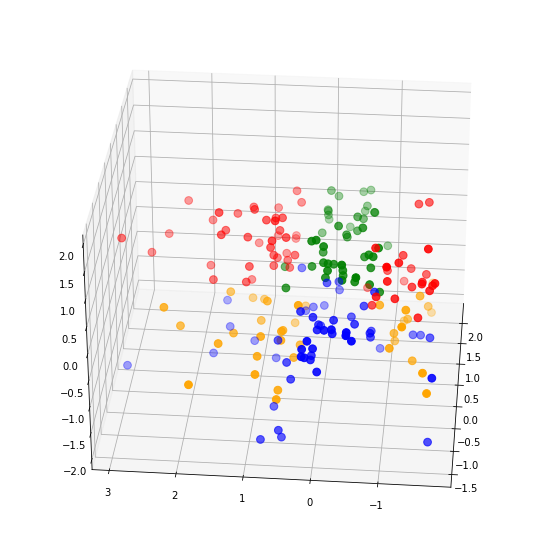

In [54]:
model = KMeans(n_clusters=4)

clusters = model.fit_predict(PCA_components.iloc[:,:2])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)
ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)

ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

Model 1 vs Model 2
Lets compare the cluster separability of this model to that of the first model:
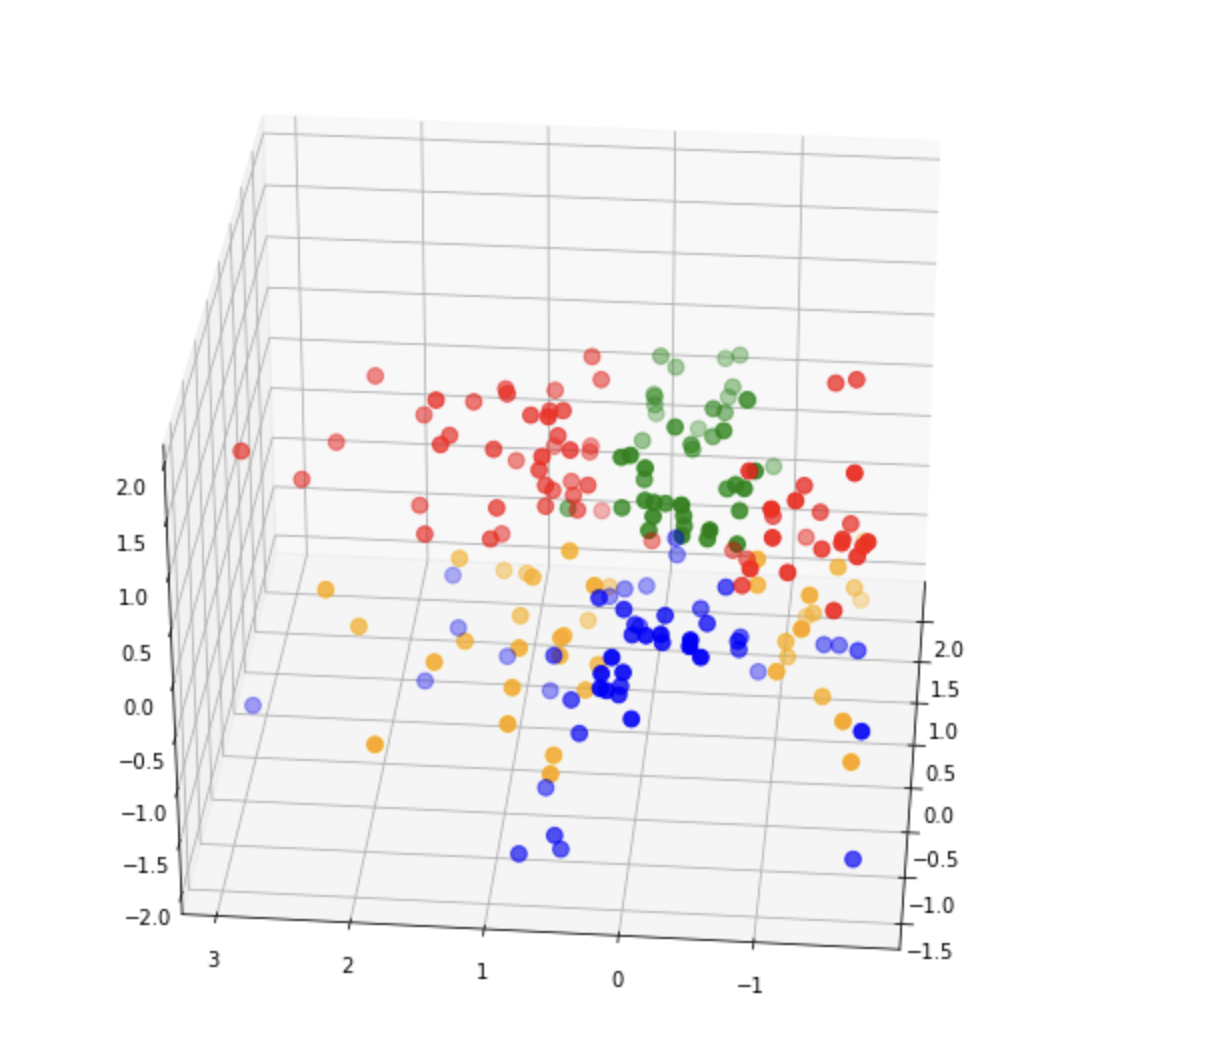

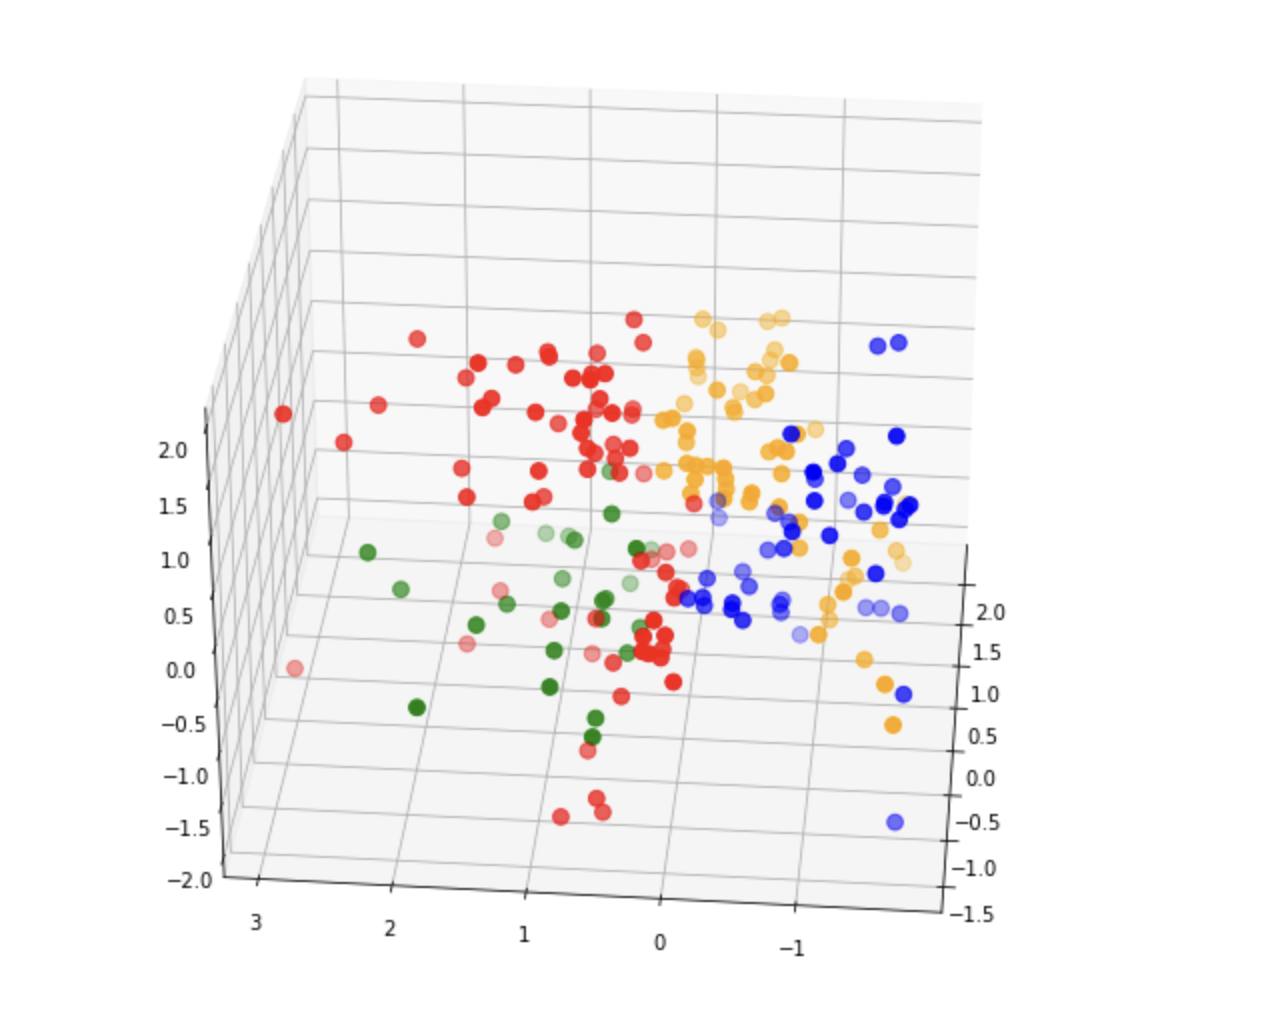

#### Notice that the clusters in the second model are much better separated than that in the first model.

#### Furthermore, the silhouette score of the second model is a lot higher.

#### For these reasons, we can pick the second model to go forward with our analysis.

### Cluster Analysis 
#### Now that we're done building these different clusters, lets try to interpret them and look at the different customer segments.

#### First, lets map the clusters back to the dataset and take a look at the head of the data frame.

In [55]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

# map back clusters to dataframe

pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,0
1,Male,21,15,81,1
2,Female,20,16,6,0
3,Female,23,16,77,1
4,Female,31,17,40,0


#### Notice that each row in the data frame is now assigned to a cluster.

#### To compare attributes of the different clusters, lets find the average of all variables across each cluster:

In [56]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
avg_df.head()

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,27.660377,59.377358,41.150943
1,1,30.064516,64.241935,80.790323
2,2,55.978723,54.425532,48.510638
3,3,47.605263,63.789474,15.000000


#### We can interpret these clusters more easily if we visualized them. Run these four lines of code to come up with different visualizations of each variable:

<AxesSubplot:xlabel='cluster', ylabel='Age'>

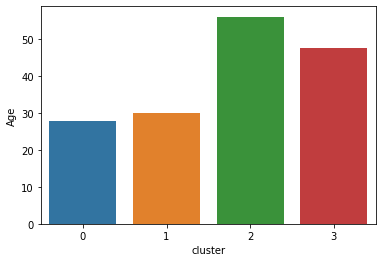

In [60]:
import seaborn as sns
sns.barplot(x='cluster',y='Age',data=avg_df)


<AxesSubplot:xlabel='cluster', ylabel='Spending Score (1-100)'>

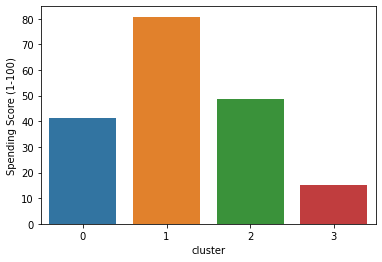

In [61]:
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df)


<AxesSubplot:xlabel='cluster', ylabel='Annual Income (k$)'>

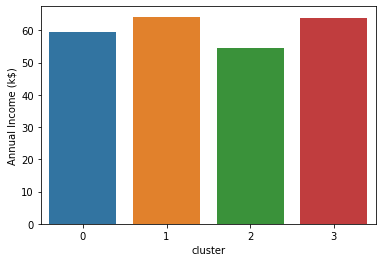

In [62]:
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df)

#### Gender Breakdown


In [64]:
df2 = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
df2

Gender
cluster Gender        
0       Female      34
        Male        19
1       Female      34
        Male        28
2       Female      26
        Male        21
3       Female      18
        Male        20

###Main attributes of each segment

> #### Cluster 0: 

   >High average income, medium spending score.
   >Mean age is around 30 and gender is predominantly female

> #### Cluster 1:

   >high average income, high spending score.
   >Mean age is around 25 and gender is predominantly female

> #### Cluster 2:

   >Low to mid average income, average spending capacity.
   >Mean age is around 50 and gender is predominantly female.
        
> #### Cluster 3: 

   > High average annual income, low spending.
   > Mean age is around 45, and gender is marginally leaning towards male.

#### It is important to note that calculating the median age would provide better insight on the distribution of age within each cluster.

#### Also, females are more highly represented in the entire dataset, which is why most clusters contain a larger number of females than males. We can find the percentage of each gender relative to the numbers in the entire dataset to give us a better idea of gender distribution.

#### Now that we know the attributes of each cluster, we can build personas around them.